In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 cd /content/drive/My Drive/Logical-Rhythm-2k20/Sports_Image_Classification

/content/drive/My Drive/Logical-Rhythm-2k20/Sports_Image_Classification


# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
from pathlib import Path
import plotly.graph_objects as go
from keras.utils import np_utils
from sklearn.utils import shuffle
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, AveragePooling2D, BatchNormalization
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Preprocessing to make proper files directory for train and validation folder to use ImageDataGenerator Class from Keras

In [ ]:
train_labels = pd.read_csv('train_labels.csv')

In [ ]:
train_labels.head()

,image,sports
0,./train/0.jpg,baseball
1,./train/1.jpg,formula1
2,./train/2.jpg,fencing
3,./train/3.jpg,motogp
4,./train/4.jpg,ice_hockey


In [ ]:
print(train_labels['sports'].value_counts())

badminton         698
football          611
volleyball        565
ice_hockey        559
tennis            555
baseball          555
boxing            542
formula1          539
swimming          531
gymnastics        531
table_tennis      530
motogp            513
wwe               508
cricket           501
fencing           494
weight_lifting    450
wrestling         432
shooting          417
hockey            405
chess             375
basketball        375
kabaddi           354
Name: sports, dtype: int64


In [ ]:
sports = set(train_labels['sports'])

In [ ]:
# print(sports)
print(len(sports))

22


In [ ]:
sports_id = {}
id_sports = {}
for idx, val in enumerate(sports):
  sports_id[val] = idx
  id_sports[idx] = val

In [ ]:
# print(id_sports)

In [ ]:
image_label = {}
for idx in train_labels.index:
  img_no = train_labels['image'][idx].split('/')[-1]
  labell = train_labels['sports'][idx]
  image_label[img_no] = labell

In [ ]:
print(len(image_label))

11040


In [ ]:
image_label['1.jpg']

'formula1'

In [ ]:
os.listdir()

['sample_submission.csv',
 'test_images_list.csv',
 'train_labels.csv',
 'logical-rythm-2k20-sports-image-classification.zip',
 'test',
 'train',
 'Code.ipynb']

In [ ]:
os.mkdir('Train')
os.mkdir('Val')

In [ ]:
os.listdir()

['sample_submission.csv',
 'test_images_list.csv',
 'train_labels.csv',
 'logical-rythm-2k20-sports-image-classification.zip',
 'test',
 'train',
 'Code.ipynb',
 'Train',
 'Val']

In [ ]:
for sport in sports:
  p1 = os.path.join('Train',sport)
  p2 = os.path.join('Val',sport)
  if not os.path.isdir(p1):
    os.mkdir(p1)
  if not os.path.isdir(p2):
    os.mkdir(p2)

In [ ]:
# os.listdir('Val')

In [ ]:
base_path = 'train'

In [ ]:
print(base_path + train_labels['image'][0][1:])

train/train/0.jpg


In [ ]:
for idx in train_labels.index:
  src = base_path + train_labels['image'][idx][1:]
  dest = 'Train/' + train_labels['sports'][idx]
  shutil.move(src,dest)

In [ ]:
SPLIT = 0.9
for f in os.listdir("Train"):
    path = "Train/"+f
    imgs = os.listdir(path)
    
    split_size = int(SPLIT*len(imgs))
    files_to_move = imgs[split_size:]
    #print(len(files_to_move))
    #print(files_to_move)
    for img_f in files_to_move:
        src = os.path.join(path,img_f)
        dest = os.path.join("Val/"+f,img_f)
        shutil.move(src,dest)

In [ ]:
print("Training Data")
for f in os.listdir("Train"):
    path = "Train/"+f
    print(f+ " "+str(len(os.listdir(path))))
   

print("\n Validation Data") 
for f in os.listdir("Train"):
    path = "Val/"+f
    print(f+ " "+str(len(os.listdir(path))))

Training Data
hockey 364
formula1 485
gymnastics 477
boxing 487
kabaddi 318
weight_lifting 405
table_tennis 477
basketball 337
fencing 444
volleyball 508
football 549
ice_hockey 503
tennis 499
swimming 477
shooting 375
wwe 457
cricket 450
wrestling 388
badminton 628
chess 337
baseball 499
motogp 461

 Validation Data
hockey 41
formula1 54
gymnastics 54
boxing 55
kabaddi 36
weight_lifting 45
table_tennis 53
basketball 38
fencing 50
volleyball 57
football 62
ice_hockey 56
tennis 56
swimming 54
shooting 42
wwe 51
cricket 51
wrestling 44
badminton 70
chess 38
baseball 56
motogp 52


In [ ]:
# print(train_labels['sports'].value_counts())

Data Preprocessing done

# Transfer Learning Using ResNet50

In [ ]:
TRAIN_DIR = "Train"
VAL_DIR = "Val"
TEST_DIR = "test"
HEIGHT = 224
WIDTH = 224
BATCH_SIZE = 64
NUM_EPOCHS = 30
NUM_CLASSES = 22
L_R = 0.01
num_train_images = 9925

In [ ]:
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, 3))

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range = 50,
      horizontal_flip=True,
      vertical_flip=True,
      zoom_range=0.3,
      width_shift_range=0.2, 
      height_shift_range=0.2, 
      shear_range=0.2,
      fill_mode='nearest'
    )

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(HEIGHT, WIDTH),
                                                    class_mode='categorical' ,
                                                    batch_size=BATCH_SIZE)

Found 9925 images belonging to 22 classes.


In [ ]:
val_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input
    )

val_generator = train_datagen.flow_from_directory(VAL_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                  class_mode='categorical' ,
                                                  shuffle = False)

Found 1115 images belonging to 22 classes.


In [ ]:
test_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input
    )

test_generator = test_datagen.flow_from_directory(TEST_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                  shuffle = False)

Found 2760 images belonging to 1 classes.


In [ ]:
# def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    # for layer in base_model.layers:
    #     layer.trainable = False

    # x = base_model.output
    # x = Flatten()(x)
    # for fc in fc_layers:
    #     # New FC layer, random init
    #     x = Dense(fc, activation='relu')(x) 
    #     x = Dropout(dropout)(x)

    # # New softmax layer
    # predictions = Dense(num_classes, activation='softmax')(x) 
    
    # finetune_model = Model(inputs=base_model.input, outputs=predictions)

    # return finetune_model

In [ ]:
print(len(base_model.layers))
for layer in base_model.layers:
      layer.trainable = False

175


In [ ]:
headModel = base_model.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = BatchNormalization()(headModel)
headModel = Dense(NUM_CLASSES, activation="softmax")(headModel)

In [ ]:
# FC_LAYERS = [1024, 1024]
# dropout = 0.5

# finetune_model = build_finetune_model(base_model, 
#                                       dropout=dropout, 
#                                       fc_layers=FC_LAYERS, 
#                                       num_classes=22)

In [ ]:
model = Model(inputs=base_model.input, outputs=headModel)

In [ ]:
adam = Adam(lr=0.01)
model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model_path = "Model_Weights/ResNet50" + "_model_weights_keras.h5"

In [ ]:
checkpoint = ModelCheckpoint(filepath = model_path, monitor="val_accuracy", mode = 'max', save_best_only=True)

In [ ]:
earlystop = EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [ ]:
history = model.fit_generator(train_generator, epochs = NUM_EPOCHS, workers=8, 
                                       steps_per_epoch = num_train_images // BATCH_SIZE,
                                       validation_data = val_generator,
                                       shuffle=True, callbacks=callbacks_list)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
155/155 [==============================] - 538s 3s/step - loss: 1.6044 - accuracy: 0.5193 - val_loss: 1.1348 - val_accuracy: 0.6565
Epoch 2/30
155/155 [==============================] - 128s 823ms/step - loss: 1.2819 - accuracy: 0.6101 - val_loss: 1.0306 - val_accuracy: 0.6852
Epoch 3/30
155/155 [==============================] - 124s 800ms/step - loss: 1.2150 - accuracy: 0.6306 - val_loss: 1.1191 - val_accuracy: 0.6547
Epoch 4/30
155/155 [==============================] - 128s 826ms/step - loss: 1.1588 - accuracy: 0.6413 - val_loss: 0.9854 - val_accuracy: 0.6906
Epoch 5/30
155/155 [==============================] - 127s 822ms/step - loss: 1.1265 - accuracy: 0.6551 - val_loss: 0.9341 - val_accuracy: 0.7175
Epoch 6/30
155/155 [==============================] - 124s 800ms/step - loss: 1.0848 - accuracy: 0.6682 - val_loss: 0.9237 - val_accuracy: 0.7157
Epoch 7/30
155/155 [==============================]

In [ ]:
# Plot the training and validation loss + accuracy
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


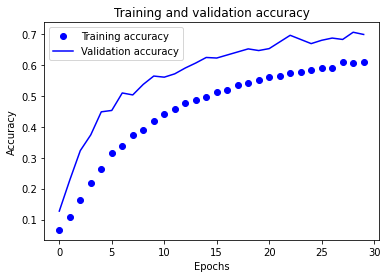

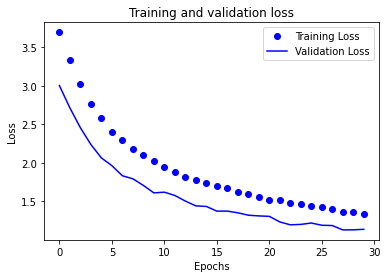

In [ ]:
plot_training(history)

In [ ]:
scores = model.evaluate_generator(val_generator) 
print("Accuracy = ", scores[1])

Accuracy =  0.7309417128562927


In [ ]:
base_model.trainable = True
for ix in range(169):
    base_model.layers[ix].trainable = False
for layer in base_model.layers:
  if isinstance(layer, BatchNormalization):
   layer.trainable = False

In [ ]:
adam = Adam(lr=0.0001)
model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_path = "Model_Weights/ResNet50" + "_model_weights_keras_finetuned.h5"

In [ ]:
BATCH_SIZE = 32

In [ ]:
checkpoint = ModelCheckpoint(filepath = model_path, monitor="val_accuracy", mode = 'max', save_best_only=True)
earlystop = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [ ]:
history = model.fit_generator(train_generator, epochs = NUM_EPOCHS, workers=8, 
                                       steps_per_epoch = num_train_images // BATCH_SIZE,
                                       validation_data = val_generator,
                                       shuffle=True, callbacks=callbacks_list)

Epoch 1/30
310/310 [==============================] - 144s 464ms/step - loss: 1.2394 - accuracy: 0.6443 - val_loss: 1.0315 - val_accuracy: 0.7211
Epoch 2/30
310/310 [==============================] - 159s 511ms/step - loss: 1.1900 - accuracy: 0.6560 - val_loss: 1.0030 - val_accuracy: 0.7291
Epoch 3/30
310/310 [==============================] - 160s 516ms/step - loss: 1.1909 - accuracy: 0.6540 - val_loss: 1.0046 - val_accuracy: 0.7265
Epoch 4/30
310/310 [==============================] - 148s 476ms/step - loss: 1.1773 - accuracy: 0.6609 - val_loss: 1.0137 - val_accuracy: 0.7220
Epoch 5/30
310/310 [==============================] - 138s 445ms/step - loss: 1.1657 - accuracy: 0.6611 - val_loss: 0.9867 - val_accuracy: 0.7291
Epoch 6/30
310/310 [==============================] - 160s 517ms/step - loss: 1.1377 - accuracy: 0.6763 - val_loss: 0.9571 - val_accuracy: 0.7435
Epoch 7/30
310/310 [==============================] - 166s 534ms/step - loss: 1.1279 - accuracy: 0.6723 - val_loss: 0.9522 -

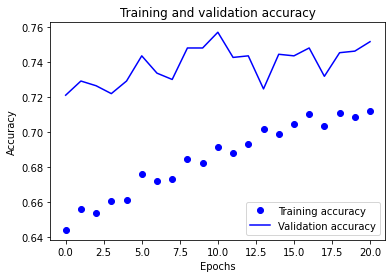

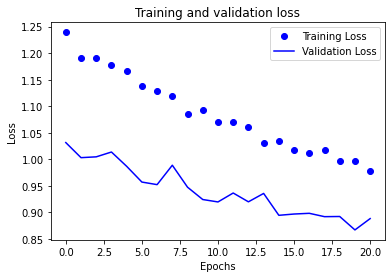

In [ ]:
plot_training(history)

In [ ]:
scores = model.evaluate_generator(val_generator) 
print("Accuracy = ", scores[1])

Accuracy =  0.749775767326355


# Predicting on test generator

In [ ]:
pred = model.predict_generator(test_generator, workers=8)

Instructions for updating:
Please use Model.predict, which supports generators.


In [ ]:
print(pred[0].argmax())

7


In [ ]:
y_classes = pred.argmax(axis=1)

In [ ]:
print(y_classes[0])

7


In [ ]:
print(pred.shape)

(2760, 22)


In [ ]:
print(val_generator.class_indices)
inv_map = {v: k for k, v in val_generator.class_indices.items()}
print(inv_map)
submission = pd.DataFrame(data= {'image': test_generator.filenames , 'sports' : np.argmax(pred, axis=1)} )
submission = submission.replace(inv_map)
print(submission.head())
filename = 'Sports_Image_Classification.csv'

submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

{'badminton': 0, 'baseball': 1, 'basketball': 2, 'boxing': 3, 'chess': 4, 'cricket': 5, 'fencing': 6, 'football': 7, 'formula1': 8, 'gymnastics': 9, 'hockey': 10, 'ice_hockey': 11, 'kabaddi': 12, 'motogp': 13, 'shooting': 14, 'swimming': 15, 'table_tennis': 16, 'tennis': 17, 'volleyball': 18, 'weight_lifting': 19, 'wrestling': 20, 'wwe': 21}
{0: 'badminton', 1: 'baseball', 2: 'basketball', 3: 'boxing', 4: 'chess', 5: 'cricket', 6: 'fencing', 7: 'football', 8: 'formula1', 9: 'gymnastics', 10: 'hockey', 11: 'ice_hockey', 12: 'kabaddi', 13: 'motogp', 14: 'shooting', 15: 'swimming', 16: 'table_tennis', 17: 'tennis', 18: 'volleyball', 19: 'weight_lifting', 20: 'wrestling', 21: 'wwe'}
           image     sports
0     test/0.jpg   football
1     test/1.jpg     motogp
2    test/10.jpg   football
3   test/100.jpg     motogp
4  test/1000.jpg  badminton
Saved file: Sports_Image_Classification.csv


In [ ]:
Sports_Image_Classification = pd.read_csv('Sports_Image_Classification.csv')

In [ ]:
img_pred = {}
for idx in Sports_Image_Classification.index:
  img_no = Sports_Image_Classification['image'][idx].split('/')[-1]
  label = Sports_Image_Classification['sports'][idx]
  img_pred[img_no] = label

In [ ]:
print(len(img_pred))

2760


In [ ]:
test_images_list = pd.read_csv('test_images_list.csv')

In [ ]:
df_pred = pd.DataFrame(columns=['image', 'sports'])

In [ ]:
cnt = 0
for idx in test_images_list.index:
  img_name = test_images_list['image'][idx]
  img_no = test_images_list['image'][idx].split('/')[-1]
  label = img_pred[img_no]
  df_pred = df_pred.append({'image' : img_name, 'sports' : label}, ignore_index=True)

In [ ]:
print(df_pred.shape)
print(df_pred.head())

(2760, 2)
          image      sports
0  ./test/0.jpg    football
1  ./test/1.jpg      motogp
2  ./test/2.jpg  ice_hockey
3  ./test/3.jpg       chess
4  ./test/4.jpg  ice_hockey


In [ ]:
# print(df_pred.shape)
# print(df_pred.head())

In [ ]:
df_pred.to_csv('second_sub.csv', index = False)